In [1]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils import data
from d2l import torch as d2l


def load_data_cifar100(batch_size=128):
    transform_train = torchvision.transforms.Compose([
        transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    transform_test = torchvision.transforms.Compose([
        transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                             download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=0)

    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=0)
    return trainloader, testloader


def train_batch(net, X, y, loss, trainer, devices):
    X = X.to(devices)
    y = y.to(devices)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train(net, train_iter, valid_iter, num_epochs, loss, trainer, lr_period,
          lr_decay, use_sl=True, device=d2l.try_gpu()):
    if use_sl:
        scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = net.to(device)
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss,
                                 trainer, device)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = evaluate_accuracy(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        if use_sl:
            scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
                     f' examples/sec on {str(device)}')


def evaluate_accuracy(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]


def train_fine_tuning(net, learning_rate, lr_period, lr_decay, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter, valid_iter = load_data_cifar100(batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    train(net, train_iter, valid_iter, num_epochs, loss, trainer, lr_period,
          lr_decay)


Files already downloaded and verified
Files already downloaded and verified


RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

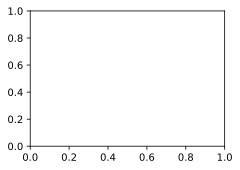

In [2]:
from torchvision import models
from d2l import torch as d2l

net = models.resnet50(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 100)
nn.init.xavier_uniform_(net.fc.weight)

devices, num_epochs, lr, wd = d2l.try_gpu(), 10, 2e-4, 5e-4
lr_period, lr_decay = 2, 0.1
#trainloader, validloader = load_data_cifar100()
loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                          weight_decay=wd)
#train(net, trainloader, validloader, num_epochs, loss, trainer, lr_period, lr_decay)
train_fine_tuning(net, lr, lr_period, lr_decay, batch_size=128, num_epochs=5)

train loss 1.107, train acc 0.678, valid acc 0.500
1036.7 examples/sec on cuda:0


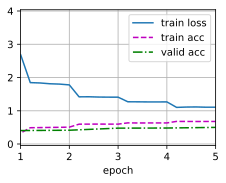

In [3]:
from torchvision import models
from d2l import torch as d2l

net = models.resnet50(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 100)
nn.init.xavier_uniform_(net.fc.weight)

devices, num_epochs, lr, wd = d2l.try_gpu(), 10, 0.0001, 5e-4
lr_period, lr_decay = 2, 0.5
#trainloader, validloader = load_data_cifar100()
loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                          weight_decay=wd)
#train(net, trainloader, validloader, num_epochs, loss, trainer, lr_period, lr_decay)
train_fine_tuning(net, lr, lr_period, lr_decay, batch_size=128, num_epochs=5)

train loss 1.075, train acc 0.690, valid acc 0.503
1066.9 examples/sec on cuda:0


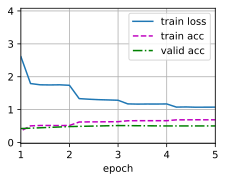

In [5]:
from torchvision import models
from d2l import torch as d2l

net = models.resnet50(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 100)
nn.init.xavier_uniform_(net.fc.weight)

devices, num_epochs, lr, wd = d2l.try_gpu(), 10, 2e-4, 5e-4
lr_period, lr_decay = 2, 0.2
#trainloader, validloader = load_data_cifar100()
loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                          weight_decay=wd)
#train(net, trainloader, validloader, num_epochs, loss, trainer, lr_period, lr_decay)
train_fine_tuning(net, lr, lr_period, lr_decay, batch_size=128, num_epochs=5)

train loss 1.964, train acc 0.470, valid acc 0.367
1069.1 examples/sec on cuda:0


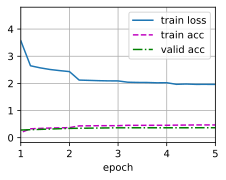

In [6]:
from torchvision import models
from d2l import torch as d2l

net = models.resnet50(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 100)
nn.init.xavier_uniform_(net.fc.weight)

devices, num_epochs, lr, wd = d2l.try_gpu(), 10, 2e-5, 5e-4
lr_period, lr_decay = 2, 0.2
#trainloader, validloader = load_data_cifar100()
loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                          weight_decay=wd)
#train(net, trainloader, validloader, num_epochs, loss, trainer, lr_period, lr_decay)
train_fine_tuning(net, lr, lr_period, lr_decay, batch_size=128, num_epochs=5)

train loss 0.959, train acc 0.717, valid acc 0.536
1057.3 examples/sec on cuda:0


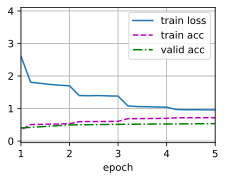

In [7]:
from torchvision import models
from d2l import torch as d2l

net = models.resnet50(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 100)
nn.init.xavier_uniform_(net.fc.weight)

devices, num_epochs, lr, wd = d2l.try_gpu(), 10, 2e-4, 5e-4
lr_period, lr_decay = 3, 0.1
#trainloader, validloader = load_data_cifar100()
loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                          weight_decay=wd)
#train(net, trainloader, validloader, num_epochs, loss, trainer, lr_period, lr_decay)
train_fine_tuning(net, lr, lr_period, lr_decay, batch_size=128, num_epochs=5)